In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np

In [205]:
latent_size = 256
w = h = 256 # output of encoder size

class VAEModel(nn.Module):
    def __init__(self) -> None:
        super(VAEModel, self).__init__()
        self.activation = nn.LeakyReLU(0.01)
        self.encoder = nn.Sequential()
        for i in range(0, 8):
            self.encoder.append(nn.Sequential(
                nn.Conv2d(2**i, 2**(i+1), 4, 2, 1),
                nn.BatchNorm2d(2**(i+1)),
                self.activation,))

        self.decoder = nn.Sequential()
        for i in range(0, 7):
            self.decoder.append(nn.Sequential(
                nn.ConvTranspose2d(2**(8-i), 2**(7-i), 4, 2, 1),
                nn.BatchNorm2d(2**(7-i)),
                self.activation,))
        self.decoder.append(nn.Sequential(
            nn.ConvTranspose2d(2, 1, kernel_size = 4, stride = 2, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
            )
        )

        self.fc_mu = nn.Linear(w, latent_size)
        self.fc_log_sigma = nn.Linear(w, latent_size)
        self.latent_de = nn.Linear(latent_size, w)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(-1, w)
        mu = self.fc_mu(h)
        log_sigma = self.fc_log_sigma(h)
        return mu, log_sigma

    def decode(self, z):
        z = z.view(-1, w, 1, 1)
        z = self.decoder(z)
        return z

    def reparameterize(self, mu, log_sigma):
        std = torch.exp(0.5*log_sigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        x = x.view(-1, 1, w, h) # add channel dimension
        mu, log_sigma = self.encode(x) # log sigma is more stable (numerically)
        z = self.reparameterize(mu, log_sigma)
        z = self.latent_de(z)
        x_hat = self.decode(z)
        return x_hat.view(-1, w, h), mu, log_sigma

In [206]:
model = VAEModel()

# Check model
A = torch.randn((10, 256, 256))
B, mu_B, log_sigma_B = model.forward(A)
B.shape, mu_B.shape, log_sigma_B.shape

(torch.Size([10, 256, 256]), torch.Size([10, 256]), torch.Size([10, 256]))

In [287]:
mse_loss = nn.MSELoss(reduction='mean')
bce_loss = nn.BCELoss(reduction='mean')
beta = 1
N = w*h
M = w
beta_norm = beta*M/N
print(f'{beta_norm = }')
def loss_fn(x, x_hat, mu, log_var): # input, reconstructed input
    MSE = mse_loss(x_hat, x)
    #BCE = bce_loss(x_hat, x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # KL divergence
    KLD = KLD.mean() # average over batch
    loss = MSE + 0.000001*KLD #beta_norm*KLD # ELBO loss with beta_norm=0.1
    #print(f'{KLD = }')
    return loss

beta_norm = 0.00390625


In [288]:
def draw(x, x_hat):
    fig, axs = plt.subplots(1, 2, figsize=(8,5))
    img_0 = x[0].detach().numpy()
    img_1 = x_hat[0].detach().numpy()
    #img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
    #img = img * 0.3081 + 0.1307
    axs[0].imshow(img_0, cmap='gray')
    axs[1].imshow(img_1, cmap='gray')
    fig.canvas.draw()

In [289]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
#optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)

In [290]:
def make_train_loader(idx):
    batch_size = 64
    train_data = torch.load(f'../augmenteddata/unaugmented_chunk_{idx}.pt')
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_loader

In [291]:
def make_dev_loader():
    batch_size = 64
    dev_data = torch.load(f'../augmenteddata/unaugmented_chunk_{9}.pt')
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return dev_loader

In [292]:
def make_loaders_2():
    batch_size = 64
    data = torch.load(f'augmenteddata/data_chunk_unaugmented.pt')
    #zero_imgs = torch.zeros((int(data.shape[0]/8), 256, 256)) # regularization data
    #minus_one_imgs = -torch.ones((int(data.shape[0]/8), 256, 256)) # regularization data
    #data = torch.cat((data, zero_imgs, one_imgs), dim=0)
    #data = torch.cat((data, minus_one_imgs), dim=0)
    N = len(data)
    N_t = int(0.9*N)
    N_d = N - N_t
    train_data, dev_data = D.random_split(data, [N_t, N_d])
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader

In [293]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()

In [294]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    for i in torch.randperm(10):
        i = int(i)
        train_loader = make_train_loader(i)
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mu, log_var = model.forward(x)
            loss = loss_fn(x, x_hat, mu, log_var)
            loss.backward()
            # plot_grad_flow(model.named_parameters())
            optimizer.step()
            losses += loss.item()
    loader_length = 10*len(train_loader) # 10 chunks
    return losses / (loader_length)  # average loss

In [295]:
def evaluate(model, dev_loader):
    model.eval()
    losses = 0

    for x in dev_loader:
        x = x.to(device)
        x_hat, mu, log_var = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        losses += loss.item()

    return losses / len(dev_loader)

In [296]:
train_losses = []
dev_losses = []

In [297]:
model = torch.load('../saved_models/model_13')
model = model.to(device)

In [298]:
from timeit import default_timer as timer
NUM_EPOCHS = 1000

#train_loader, dev_loader = make_loaders()
#train_loader, dev_loader = make_loaders_2()
dev_loader = make_dev_loader()
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    train_losses.append(train_loss)
    end_time = timer()
    dev_loss = evaluate(model, dev_loader)
    dev_losses.append(dev_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Dev loss: {dev_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 0.161, Dev loss: 0.162, Epoch time = 112.257s
Epoch: 2, Train loss: 0.161, Dev loss: 0.165, Epoch time = 110.363s
Epoch: 3, Train loss: 0.161, Dev loss: 0.164, Epoch time = 110.882s
Epoch: 4, Train loss: 0.161, Dev loss: 0.164, Epoch time = 110.072s


KeyboardInterrupt: 

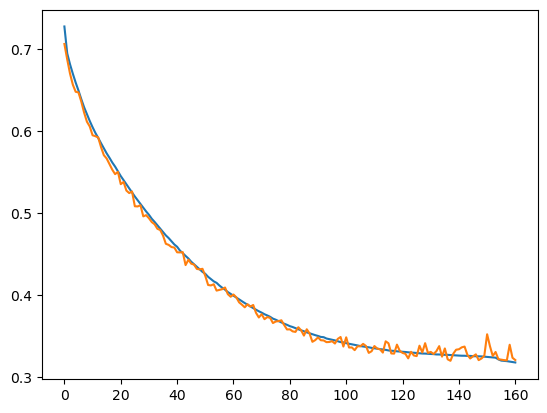

In [221]:
torch.save(model, '../saved_models/model_14')
torch.save(torch.Tensor(train_losses), '../losses/train_losses_model_14')
torch.save(torch.Tensor(dev_losses), '../losses/dev_losses_model_14')
plt.plot((train_losses))
plt.plot((dev_losses))

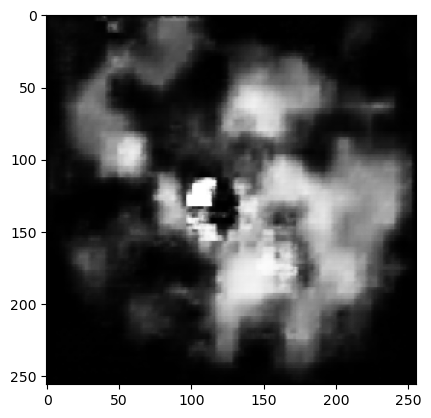

In [306]:
model.eval()
#x_test = next(iter(dev_loader))[0].view(1, 256, 256).to(device)
#x_test = torch.zeros((1, 256, 256)).to(device)
#x_hat_test = model.forward(x_test)[0]
#draw(x_test.cpu(), x_hat_test.cpu())
#mse_loss(x_test, x_hat_test)
x_sampled = model.decode(torch.randn(1, latent_size).to(device)).view(1, 256, 256).cpu()
plt.imshow(x_sampled[0].detach().numpy(), cmap='gray')